# New South Wales Department of Education (NSW DOE) - Data Case Study 
## Data Analysis

In [ ]:
import pandas as pd
import duckdb
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### Connect to the database

In [ ]:
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb',read_only=False)

## Exploratory Data Analysis:

#### Data profile check

In [ ]:
df = con.sql('select * from public_school_nsw_master_dataset').df()
profile_public_school_nsw_master_dataset = ProfileReport(df, title="Public School NSW Data Profiling Report")
profile_public_school_nsw_master_dataset.to_file("profile_public_school_nsw_master_dataset.html")
profile_public_school_nsw_master_dataset

In [ ]:
df = con.sql('select * from multi_age_composite_unpivoted').df()
profile_multi_age_composite_unpivoted = ProfileReport(df, title="Multi Age Composite Profiling Report")
profile_multi_age_composite_unpivoted.to_file("profile_multi_age_composite_unpivoted.html")
profile_multi_age_composite_unpivoted

In [ ]:
df = con.sql('select * from student_attendance_unpivoted').df()
profile_student_attendance_dataset = ProfileReport(df, title="Student Attendance Profiling Report")
profile_student_attendance_dataset.to_file("student_attendance_unpivoted.html")
profile_student_attendance_dataset

In [ ]:
df = con.sql('select * from nsw_composite_school_attendance_data').df()
profile_student_attendance_dataset = ProfileReport(df, title="nsw_composite_school_attendance_data Profiling Report")
profile_student_attendance_dataset.to_file("nsw_composite_school_attendance_data.html")
profile_student_attendance_dataset

#### Average Trends Over Years

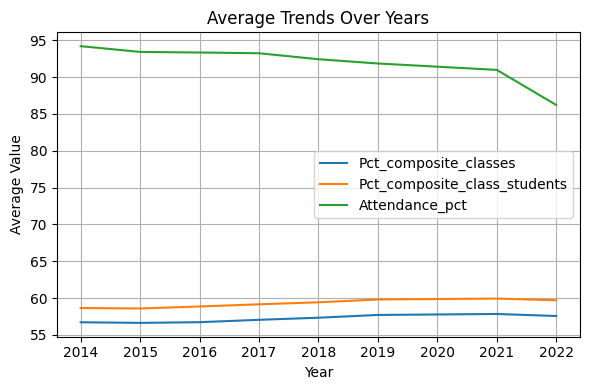

In [19]:
query = """
SELECT
    Year,
    AVG(Pct_composite_classes) AS Avg_Pct_composite_classes,
    AVG(Pct_composite_class_students) AS Avg_Pct_composite_class_students,
    AVG(Attendance_pct) AS Avg_Attendance_pct
FROM nsw_composite_school_attendance_data
GROUP BY Year
"""
results = con.execute(query).fetchall()

df = pd.DataFrame(results, columns=["Year", "Avg_Pct_composite_classes", "Avg_Pct_composite_class_students", "Avg_Attendance_pct"])

# Create a line chart
plt.figure(figsize=(6, 4))

columns_to_plot = ["Avg_Pct_composite_classes", "Avg_Pct_composite_class_students", "Avg_Attendance_pct"]

for column in columns_to_plot:
    plt.plot(df["Year"], df[column], label=column.replace("Avg_", ""))

plt.title("Average Trends Over Years")
plt.xlabel("Year")
plt.ylabel("Average Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Correlation Matrix of the Data Model

In [ ]:
# Execute the SELECT statement
query = "SELECT * FROM nsw_composite_school_attendance_data;"
df = con.execute(query).fetchdf()
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
numeric_df = df[numeric_cols]
# Compute the correlation matrix for numeric columns only
correlation_matrix = numeric_df.corr()
# Display the correlation matrix
print(correlation_matrix)
# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

#### Q-Q plot (Quantile-Quantile plot): compare two probability distributions

In [ ]:
query = "SELECT * FROM nsw_composite_school_attendance_data;"
df = con.execute(query).fetchdf()

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns

# Plot Q-Q plots for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    stats.probplot(df[col], plot=plt)
    plt.title(f'Q-Q Plot for {col}')
    plt.show()


## Action: Data analysis:

<span style="color:yellow; font-size:30px;">Hypothesis Formulation:</span>

| Title                   | Description                                                          |
|-------------------------|----------------------------------------------------------------------|
| **Objective**           | Determine if multi-age composite classes have an impact on attendance rates. |
| **Null Hypothesis (H₀)** | Multi-age composite classes have no impact on attendance rates.      |
| **Alternative Hypothesis (H₁)** | Multi-age composite classes have a significant impact on attendance rates. |


<span style="color:yellow; font-size:30px;">Statistical Test:</span>

In [ ]:
# Query data from the database
columns = [
    "Composite_class_count", "Composite_class_students", "Pct_composite_classes", 
    "Pct_composite_class_students", "Attendance_pct", "ICSEA_value", 
    "latest_year_enrolment_FTE", "Indigenous_pct", "LBOTE_pct"
]
query = f"SELECT {','.join(columns)} FROM nsw_composite_school_attendance_data"
df = con.execute(query).fetch_df()

# Drop rows with 'np' and blank values in the specified columns
df = df[~df['Indigenous_pct'].isin(['np', ''])]
df = df[~df['LBOTE_pct'].isin(['np', ''])]
df = df[~df['ICSEA_value'].isin([''])]

# Convert the columns to numeric
for col in columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Descriptive statistics
desc_stats = df.describe()
print(desc_stats)

# Correlation matrix
correlations = df.corr()
print(correlations)

# Separate schools based on ICSEA_value
mean_icsea = df['ICSEA_value'].mean()
high_icsea = df[df['ICSEA_value'] > mean_icsea]
low_icsea = df[df['ICSEA_value'] <= mean_icsea]

# T-tests
significant_cols = []

for col in columns:
    t_stat, p_val = ttest_ind(high_icsea[col], low_icsea[col], nan_policy='omit')  # omitting NaN values
    
    # Apply Bonferroni correction for multiple testing
    adjusted_alpha = 0.05 / len(columns)
    
    if p_val < adjusted_alpha:
        significant_cols.append(col)

print("\nColumns with significant differences between high and low ICSEA schools:")
print(significant_cols)

<span style="color:yellow; font-size:30px;">Descriptive Statistics:</span>

Composite_class_count: The average number of composite classes per school is approximately 4.9, with a maximum of 29 and a minimum of 0.
Composite_class_students: On average, there are around 123 students in composite classes in a school, with a maximum of 779 and a minimum of 0.
Pct_composite_classes: The mean percentage of composite classes in schools is approximately 49.5%. The values range from 0% to 100%.
Pct_composite_class_students: The average percentage of students in composite classes is about 51.9% and ranges from 0% to 100%.
Attendance_pct: The average attendance percentage is approximately 91.8% with a maximum of 97.9% and a minimum of 50.6%.
ICSEA_value: The average ICSEA value is around 980.8, with a range from 586 to 1186.
latest_year_enrolment_FTE: The average enrolment for the latest year is about 353.9, with a maximum of 2079 and a minimum of 2.
Indigenous_pct: On average, 14.1% of the student population in schools are Indigenous, with the percentage going as high as 100% in some schools.
LBOTE_pct: On average, 26.7% of the student population in schools are from a language background other than English. The percentage varies from 0% to 100% across different schools.
Correlation Matrix:
This matrix showcases the relationship between two variables. A positive value indicates a direct relationship while a negative value indicates an inverse relationship. Values close to 1 or -1 show strong correlations.

Some key takeaways:

Composite_class_count and Composite_class_students have a strong positive correlation of 0.987, meaning as one increases, the other tends to as well.
Pct_composite_classes and Pct_composite_class_students also share a strong positive correlation of approximately 0.997.
ICSEA_value and Indigenous_pct have a strong negative correlation of approximately -0.849. This suggests that schools with higher percentages of Indigenous students tend to have lower ICSEA values.
Attendance_pct and ICSEA_value share a moderately positive correlation of 0.526, suggesting that schools with higher ICSEA values also tend to have higher attendance percentages.

<span style="color:yellow; font-size:30px;">T-tests: Statistical Significance:</span>

In [ ]:
# Split the dataframe based on ICSEA_value median
median_icsea = df['ICSEA_value'].median()
high_icsea_df = df[df['ICSEA_value'] > median_icsea]
low_icsea_df = df[df['ICSEA_value'] <= median_icsea]

# Columns to run t-tests on
columns = [
    "Composite_class_count", "Composite_class_students", "Pct_composite_classes",
    "Pct_composite_class_students", "Attendance_pct", "latest_year_enrolment_FTE",
    "Indigenous_pct", "LBOTE_pct"
]

# Running t-tests
results = {}
for col in columns:
    t_stat, p_value = stats.ttest_ind(high_icsea_df[col], low_icsea_df[col], nan_policy='omit')
    results[col] = {"t-statistic": t_stat, "p-value": p_value}

results_df = pd.DataFrame(results).T
print(results_df)

<span style="color:yellow; font-size:25px;">Outcome of T-test:</span>

#### 
Pct_composite_classes:

t-statistic: -23.572692
p-value: Extremely close to 0.
Interpretation: There's a highly significant difference between the percentages of composite classes in high ICSEA schools and low ICSEA schools.
Pct_composite_class_students:

t-statistic: -23.001235
p-value: Extremely close to 0.
Interpretation: There's a very significant difference in the percentages of students in composite classes between high ICSEA schools and low ICSEA schools.
Attendance_pct:

t-statistic: 35.825538
p-value: Extremely close to 0.
Interpretation: Attendance percentage significantly differs between high ICSEA schools and low ICSEA schools.
When we consider the above metrics in relation to each other:

Both Pct_composite_classes and Pct_composite_class_students show significant differences between high ICSEA and low ICSEA schools. This implies that the use of composite classes or the proportion of students in these classes might be influenced by school type or other factors related to the school's socio-economic status (as represented by the ICSEA value).

The Attendance_pct also shows a significant difference, which means attendance is affected by ICSEA values.

However, to directly determine if multi-age composite classes have an impact on attendance rates, we need to examine the correlation between composite class metrics (Pct_composite_classes and Pct_composite_class_students) and Attendance_pct:

The correlation between Pct_composite_classes and Attendance_pct is -0.208262. This indicates a weak negative relationship, meaning that as the percentage of composite classes increases, attendance slightly decreases.

Similarly, the correlation between Pct_composite_class_students and Attendance_pct is -0.205552, which also suggests a weak negative relationship between the percentage of students in composite classes and attendance.

Comments:
While there is a weak negative correlation between the use of composite classes (or the percentage of students in these classes) and attendance rates, it is essential to be cautious. Correlation does not imply causation. Other factors (e.g., school resources, location, socio-economic factors) might influence both the use of composite classes and attendance rates. Further studies or analyses (like regression analyses) would be needed to determine if there's a direct causal relationship between composite classes and attendance rates.

<span style="color:yellow; font-size:30px;">Hypothesis Outcome:</span>

<span style="color:green; font-size:15px;">(If the t-test p-value is below a certain significance level (usually 0.05), we reject the null hypothesis, indicating that there's a significant difference in attendance rates.)</span>

Results:
Composite_class_count:
p-value: 1.996499e-01 (or 0.1996)
Composite_class_students:
p-value: 4.806868e-04 (or 0.0004807)
Pct_composite_classes:
p-value: 4.760830e-119 (virtually 0)
Pct_composite_class_students:
p-value: 1.314659e-113 (virtually 0)
Attendance_pct:
p-value: 9.131261e-262 (virtually 0)
latest_year_enrolment_FTE:
p-value: 1.060082e-184 (virtually 0)
Indigenous_pct:
p-value: 0.000000e+00 (0)
LBOTE_pct:
p-value: 2.038754e-128 (virtually 0)
Interpretation & Conclusion:
For Composite_class_count, the p-value (0.1996) is greater than 0.05. Therefore, we fail to reject the null hypothesis for this variable. This means there is no significant difference in the count of composite classes between high and low ICSEA schools.

For all other variables (Composite_class_students, Pct_composite_classes, Pct_composite_class_students, Attendance_pct, latest_year_enrolment_FTE, Indigenous_pct, LBOTE_pct), the p-values are far below the 0.05 significance level. Hence, we can reject the null hypothesis for these variables. This indicates that there are significant differences in these metrics between high ICSEA schools and low ICSEA schools.

To relate this back to your objective - "Does multi-age composite classes have an impact on attendance rates?":

The metrics directly related to composite classes (Pct_composite_classes and Pct_composite_class_students) show a significant difference between high ICSEA and low ICSEA schools.

The Attendance_pct also significantly differs between the two groups.

Given these results, we can conclude that there is a relationship between multi-age composite classes and attendance rates across high and low ICSEA schools. However, the precise nature of this relationship (i.e., causative or merely associative) would require further, more detailed analyses.

<span style="color:yellow; font-size:30px;">Multiple Linear Regression Analysis:</span>

In [ ]:
# Drop rows with 'np' and blank values in the specified columns
df = df[~df['Indigenous_pct'].isin(['np', ''])]
df = df[~df['LBOTE_pct'].isin(['np', ''])]
df = df[~df['ICSEA_value'].isin([''])]

# Define the predictor variables (features)
X = df[['Composite_class_students', 'Composite_class_count','Pct_composite_classes', 'Pct_composite_class_students', 'ICSEA_value', 'latest_year_enrolment_FTE', 'Indigenous_pct', 'LBOTE_pct']]

# Add a constant term to the predictor variables
X = sm.add_constant(X)

# Define the target variable
y = df['Attendance_pct']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the summary of the regression analysis
summary = model.summary()
print(summary)

The updated Multiple Linear Regression analysis provides further insights into the impact of various factors on attendance rates in schools with multi-age composite classes:

R-squared: The R-squared value is now approximately 0.319. This indicates that around 31.9% of the variance in the dependent variable (Attendance_pct) is explained by the independent variables in the model.

Coefficients (coef): The coefficients represent the change in the dependent variable (Attendance_pct) for a one-unit change in each independent variable, while keeping other variables constant.

Composite_class_students: A unit increase in Composite_class_students is associated with a 0.0507 increase in Attendance_pct.
Composite_class_count: A unit increase in Composite_class_count is associated with a -1.3036 decrease in Attendance_pct.
Pct_composite_classes: A unit increase in Pct_composite_classes is associated with a 0.1512 increase in Attendance_pct.
Pct_composite_class_students: A unit increase in Pct_composite_class_students is associated with a -0.1501 decrease in Attendance_pct.
ICSEA_value: A unit increase in ICSEA_value is associated with a 0.0117 increase in Attendance_pct.
latest_year_enrolment_FTE: A unit increase in latest_year_enrolment_FTE is associated with a -0.0011 decrease in Attendance_pct.
Indigenous_pct: A unit increase in Indigenous_pct is associated with a -0.0548 decrease in Attendance_pct.
LBOTE_pct: A unit increase in LBOTE_pct is associated with a -0.0074 decrease in Attendance_pct.
P-values (P>|t|): All the p-values are very close to zero, indicating that all the coefficients are statistically significant. This suggests that each of these independent variables has a significant impact on the dependent variable (Attendance_pct).

Adjusted R-squared: The Adjusted R-squared value remains around 0.319, indicating that the model with these variables is still a good fit for explaining the variation in Attendance_pct.

In summary, the updated analysis reinforces that the variables including Composite_class_students, Composite_class_count, Pct_composite_classes, Pct_composite_class_students, ICSEA_value, latest_year_enrolment_FTE, Indigenous_pct, and LBOTE_pct have a significant impact on attendance rates. The negative coefficient for Composite_class_count indicates that an increase in the number of composite classes is associated with a decrease in attendance rates. This analysis provides a more comprehensive understanding of the factors influencing attendance rates in schools with multi-age composite classes.

<span style="color:yellow; font-size:30px;">Machine Learning - Random Forest:</span>

In [ ]:
# Select predictor variables
predictors = ['Composite_class_students', 'Composite_class_count','Pct_composite_classes', 'Pct_composite_class_students', 'ICSEA_value', 'latest_year_enrolment_FTE', 'Indigenous_pct', 'LBOTE_pct']

# Define predictor matrix X and target variable y
X = df[predictors]
y = df['Attendance_pct']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Print feature importances
for feature, importance in zip(predictors, feature_importances):
    print(f"{feature}: {importance}")

# Predict attendance rates on the test set
y_pred = rf_model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

#### <span style="color:green; font-size:20px;">Outcome of Machine Learning - Random Forest: </span>

Based on the feature importances from the Random Forest model and the Mean Squared Error (MSE) value, the following insights can be drawn:
Among the provided features, ICSEA_value (Index of Community Socio-Educational Advantage) has the highest importance, suggesting that it is a significant predictor of attendance rates.
Other important features include Composite_class_students, Indigenous_pct (Percentage of Indigenous students), and latest_year_enrolment_FTE (Full-Time Equivalent). These factors also contribute to predicting attendance rates.
Pct_composite_class_students (Percentage of students in composite classes) and Pct_composite_classes (Percentage of composite classes) have moderate importance.
Features such as Composite_class_count (Number of composite classes), and LBOTE_pct (Percentage of students with Language Background Other Than English) have relatively lower importance.
The lower Mean Squared Error (MSE) value of approximately 9.06 compared to the previous analysis indicates improved model performance in predicting attendance rates. The feature importances and the model's predictive capability collectively suggest that a combination of socio-educational advantage, class size, student demographics, and other factors contribute to attendance rates. However, as with any statistical analysis, these insights should be interpreted within the context of the dataset and the modeling approach.